In [68]:
#URL что бы собрать отзывы
#Импортируем библиотеки
import requests
import bs4
from multiprocessing import Pool
import codecs
import pandas as pd
import matplotlib.pyplot
%matplotlib inline

# Собираем данные от отзывах с товары - mail.ru 

In [103]:
marks = []
comments = []
pagecount = 100

for i in range(1, pagecount):
    url = "https://torg.mail.ru/review/goods/?page="+str(i)
    req = requests.get(url)
    parser = bs4.BeautifulSoup(req.text, "html.parser")
    #print parser.prettify()
    for review in parser.findAll("div", attrs={"class": "review-item__body"}):
        str_value = review.find("span", attrs={"class": "review-item__rating-counter"}).text
        comment_node = review.find("a", attrs={"class": "more"})
        title = review.find("div", attrs={"class": "review-item__title"})
        if title != None and title.text == u"Достоинства": 
            marks.append(1)
            comments.append(title.findNext("p").text)
            title = title.findNext("div", attrs={"class": "review-item__title"})
            if title != None and title.text == u"Недостатки": 
                marks.append(0)
                comments.append(title.findNext("p").text)
        
data = pd.DataFrame({"comments" : comments, "marks": marks})

Количество данных -  2367


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010B5E518>]], dtype=object)

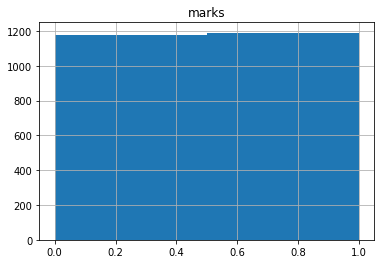

In [106]:
print "Количество данных - ", len(data)
#Гистограмма распределения классов 
data.hist(bins=2)

In [107]:
#Импортируем доп библиотеки
import nltk
import numpy as np
import unicodedata

from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

#Функция создания каскада - пайплайна из ветроризатора, трансформатора и класификатора
def text_classifier(vectorizer, transformer ,classifier):
    if (transformer is None) :
        return Pipeline(
                [("vectorizer", vectorizer),
                 ("classifier", classifier)]
            )
    else: 
        return Pipeline(
            [("vectorizer", vectorizer),
             ("transformer", transformer),
             ("classifier", classifier)]
        )

C:\Users\KONYAYEV.MAKSIM\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [108]:
#Подбор лучших параметров
from sklearn.model_selection import GridSearchCV

ngram_range = [(1,2),(1,3),(1,4),(2,3),(2,4),(3,5),(4,9),(5,9)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["word", "char", "char_wb"],
    "vectorizer__ngram_range": ngram_range,
    #"vectorizer__stop_words": [None, "english"],
    "classifier": [LogisticRegression(), LinearSVC(), SGDClassifier()],
    #"vectorizer__max_df": np.arange(0.9,1.0, 0.05),
    #"vectorizer__min_df": np.arange(0.0,0.10, 0.05),
}

In [110]:
#Загрузка данных
X = data.comments.values 
Y = data.marks.values

In [111]:
pipLine = text_classifier(CountVectorizer(), None ,LinearSVC())
gridSearchCV = GridSearchCV(pipLine, param_grid=param_grid, n_jobs = -1)
gridSearchCV.fit(X, Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 5), (4, 9), (5, 9)], 'classifier': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', rando...  strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)]},
       pre_dispatch='2*n_jobs', refit=True, return

In [112]:
gridSearchCV.best_params_

{'classifier': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'vectorizer': TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(3, 5), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 'vectorizer__analyzer': 'char',
 'vectorizer__ngram_range': (3, 5)}

In [113]:
gridSearchCV.best_score_

0.88001689902830582

In [114]:
#Использование лучших настроек
pl = text_classifier(TfidfVectorizer(ngram_range=(3, 5), analyzer='char'),None,LinearSVC())

pl.fit(X, Y)
#predict = pl.predict(test_data.text.values)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(3, 5), norm=u'l2', preprocessor=None, smooth_idf...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [125]:
text_reader = open("test_mod.txt", "r")
testInput = list(text_reader)
testOutput = pl.predict(testInput)


[0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1
 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0]


In [121]:
import pickle
#Сохранение данных в файл с помощью pickle
pickle.dump(pl, open( "defaultClassifier.pkl", "wb" ))

In [142]:
submitFile = open("week6.txt", "w")
submitFile.write("Id,y\n")
currentId = 0;
for value in testOutput:
    strValue = "neg"
    if value == 1:
        strValue = "pos"
    submitFile.write(str(currentId)+","+strValue+"\n")
    currentId = currentId+1
submitFile.close()